<a href="https://colab.research.google.com/github/varsha6319/Product_Rec/blob/main/Step_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# # Step 1: Install PySpark
# !pip install pyspark

In [2]:
!pip install pyspark==3.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 23.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764004 sha256=71339a4d92f48bdfa177bdd2d45d50328bd2e7843d828457100508ed9615612e
  Stored in directory: /root/.cache/pip/wheels/81/9c/6c/d5200fcf351ffa39cbe09911e99703283624cd037df58070d9
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, to_date, percentile_approx, round, concat_ws
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier

import zipfile
import os
import matplotlib.pyplot as plt


In [4]:
spark = SparkSession.builder \
    .appName("RandomForest_GPU") \
    .config("spark.executor.memory", "32g") \
    .config("spark.executor.cores", "4") \
    .config("spark.ui.port", "4040").getOrCreate()

In [5]:
# Function to unzip the file
def unzip_file(zip_path, output_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)

train_data_path = "/content/drive/My Drive/santander-product-recommendation/train_ver2.csv.zip"
test_data_path = "/content/drive/My Drive/santander-product-recommendation/test_ver2.csv.zip"

# Unzip train and test data files
train_unzipped_dir = "/content/train_data"
test_unzipped_dir = "/content/test_data"
unzip_file(train_data_path, train_unzipped_dir)
unzip_file(test_data_path, test_unzipped_dir)

train_csv_path = os.path.join(train_unzipped_dir, os.listdir(train_unzipped_dir)[0])
test_csv_path = os.path.join(test_unzipped_dir, os.listdir(test_unzipped_dir)[0])

# Read train and test data from CSV files
train_df = spark.read.option("header", True).csv(train_csv_path, inferSchema=True)
test_df = spark.read.option("header", True).csv(test_csv_path, inferSchema=True)


In [6]:
train_df.printSchema()
test_df.printSchema()

root
 |-- fecha_dato: timestamp (nullable = true)
 |-- ncodpers: double (nullable = true)
 |-- ind_empleado: string (nullable = true)
 |-- pais_residencia: string (nullable = true)
 |-- sexo: string (nullable = true)
 |-- age: string (nullable = true)
 |-- fecha_alta: timestamp (nullable = true)
 |-- ind_nuevo: string (nullable = true)
 |-- antiguedad: string (nullable = true)
 |-- indrel: string (nullable = true)
 |-- ult_fec_cli_1t: timestamp (nullable = true)
 |-- indrel_1mes: string (nullable = true)
 |-- tiprel_1mes: string (nullable = true)
 |-- indresi: string (nullable = true)
 |-- indext: string (nullable = true)
 |-- conyuemp: string (nullable = true)
 |-- canal_entrada: string (nullable = true)
 |-- indfall: string (nullable = true)
 |-- tipodom: string (nullable = true)
 |-- cod_prov: string (nullable = true)
 |-- nomprov: string (nullable = true)
 |-- ind_actividad_cliente: string (nullable = true)
 |-- renta: double (nullable = true)
 |-- segmento: string (nullable = true

In [7]:
column_mapping = {
    "fecha_dato": "date",
    "ncodpers": "customer_code",
    "ind_empleado": "employee_index",
    "pais_residencia": "country_residence",
    "sexo": "sex",
    "age": "age",
    "fecha_alta": "first_contract_date",
    "ind_nuevo": "new_customer_index",
    "antiguedad": "customer_seniority",
    "indrel": "primary_customer_index",
    "ult_fec_cli_1t": "last_primary_date",
    "indrel_1mes": "customer_type_start_month",
    "tiprel_1mes": "customer_relation_type_start_month",
    "indresi": "residence_index",
    "indext": "foreigner_index",
    "conyuemp": "spouse_employee_index",
    "canal_entrada": "entry_channel",
    "indfall": "deceased_index",
    "tipodom": "address_type",
    "cod_prov": "province_code",
    "nomprov": "province_name",
    "ind_actividad_cliente": "customer_activity_index",
    "renta": "household_income",
    "segmento": "customer_segment",
    "ind_ahor_fin_ult1": "savings_account",
    "ind_aval_fin_ult1": "guarantees",
    "ind_cco_fin_ult1": "current_accounts",
    "ind_cder_fin_ult1": "derivada_account",
    "ind_cno_fin_ult1": "payroll_account",
    "ind_ctju_fin_ult1": "junior_account",
    "ind_ctma_fin_ult1": "mas_particular_account",
    "ind_ctop_fin_ult1": "particular_account",
    "ind_ctpp_fin_ult1": "particular_plus_account",
    "ind_deco_fin_ult1": "short_term_deposits",
    "ind_deme_fin_ult1": "medium_term_deposits",
    "ind_dela_fin_ult1": "long_term_deposits",
    "ind_ecue_fin_ult1": "e_account",
    "ind_fond_fin_ult1": "funds",
    "ind_hip_fin_ult1": "mortgage",
    "ind_plan_fin_ult1": "pension_plans",
    "ind_pres_fin_ult1": "loans",
    "ind_reca_fin_ult1": "taxes",
    "ind_tjcr_fin_ult1": "credit_card",
    "ind_valo_fin_ult1": "securities",
    "ind_viv_fin_ult1": "home_account",
    "ind_nomina_ult1": "payroll",
    "ind_nom_pens_ult1": "pensions_nom",
    "ind_recibo_ult1": "direct_debit"
}

In [8]:
for old_col, new_col in column_mapping.items():
  train_df = train_df.withColumnRenamed(old_col, new_col)

train_df.show()

+-------------------+-------------+--------------+-----------------+---+---+-------------------+------------------+------------------+----------------------+-----------------+-------------------------+----------------------------------+---------------+---------------+---------------------+-------------+--------------+------------+-------------+-------------+-----------------------+------------------+------------------+---------------+----------+----------------+----------------+---------------+--------------+----------------------+------------------+-----------------------+-------------------+--------------------+------------------+---------+-----+--------+-------------+-----+-----+-----------+----------+------------+-------+------------+------------+
|               date|customer_code|employee_index|country_residence|sex|age|first_contract_date|new_customer_index|customer_seniority|primary_customer_index|last_primary_date|customer_type_start_month|customer_relation_type_start_month|re

In [9]:
for old_col, new_col in column_mapping.items():
    test_df = test_df.withColumnRenamed(old_col, new_col)
test_df.show()

+-------------------+-------------+--------------+-----------------+---+----+-------------------+------------------+------------------+----------------------+-----------------+-------------------------+----------------------------------+---------------+---------------+---------------------+-------------+--------------+------------+-------------+--------------+-----------------------+----------------+------------------+
|               date|customer_code|employee_index|country_residence|sex| age|first_contract_date|new_customer_index|customer_seniority|primary_customer_index|last_primary_date|customer_type_start_month|customer_relation_type_start_month|residence_index|foreigner_index|spouse_employee_index|entry_channel|deceased_index|address_type|province_code| province_name|customer_activity_index|household_income|  customer_segment|
+-------------------+-------------+--------------+-----------------+---+----+-------------------+------------------+------------------+-------------------

In [10]:
# Calculate null percentages for each column
null_percentages = train_df.agg(*[(1 - (F.count(F.col(c)) / F.count('*'))) * 100 for c in train_df.columns])

# # Rename the columns for clarity
null_percentages = null_percentages.select([F.col(c).alias(f"{train_df.columns[i]}_null_percentage") for i, c in enumerate(null_percentages.columns)])

# Show the null percentages
null_percentages.show()

+--------------------+-----------------------------+------------------------------+---------------------------------+-------------------+-------------------+-----------------------------------+----------------------------------+----------------------------------+--------------------------------------+---------------------------------+-----------------------------------------+--------------------------------------------------+-------------------------------+-------------------------------+-------------------------------------+-----------------------------+------------------------------+----------------------------+-----------------------------+-----------------------------+---------------------------------------+--------------------------------+--------------------------------+-------------------------------+--------------------------+--------------------------------+--------------------------------+-------------------------------+------------------------------+-------------------------

In [11]:
train_df = train_df.drop("last_primary_date", "spouse_employee_index")
test_df = test_df.drop("last_primary_date", "spouse_employee_index")

In [12]:
print("Shape of train DataFrame: ({}, {})".format(train_df.count(), len(train_df.columns)))
print("Shape of test DataFrame: ({}, {})".format(test_df.count(), len(test_df.columns)))

Shape of train DataFrame: (13647309, 46)
Shape of test DataFrame: (929615, 22)


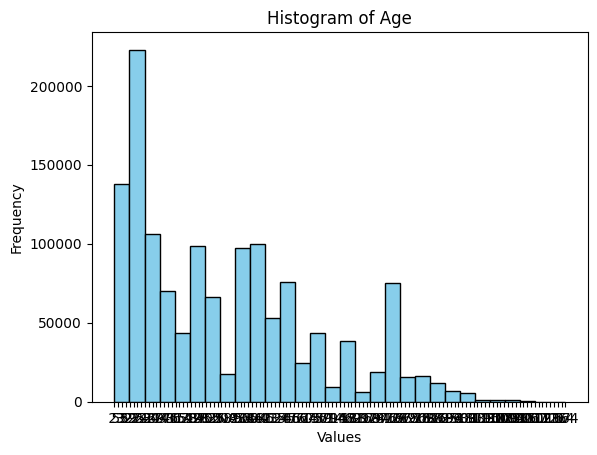

In [13]:
sample_fraction = 0.1
sampled_data = train_df.select('age').sample(fraction=sample_fraction).rdd.flatMap(lambda x: x).collect()

# Plot histogram
plt.hist(sampled_data, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Age')
plt.show()

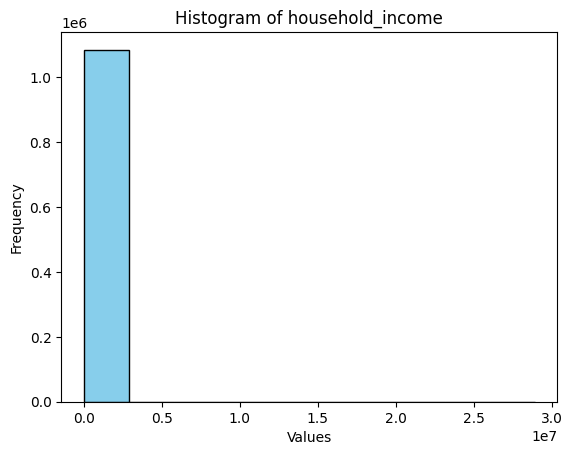

In [14]:

sample_fraction = 0.1  # Adjust as needed

sampled_data = train_df.select('household_income').dropna().sample(fraction=sample_fraction).rdd.flatMap(lambda x: x).collect()

# Plot histogram
plt.hist(sampled_data, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of household_income')
plt.show()

In [15]:
def preprocess_data(df):
    df_processed = df \
        .withColumn("date", to_date(col("date"), "yyyy-MM-dd")) \
        .withColumn("employee_index", when(col("employee_index") == "A", 1)
                      .when(col("employee_index") == "B", 2)
                      .when(col("employee_index") == "F", 3)
                      .when(col("employee_index") == "N", 4)
                      .when(col("employee_index") == "S", 5)
                      .otherwise(col("employee_index").cast("int"))) \
        .withColumn("first_contract_date", to_date(col("first_contract_date"), "yyyy-MM-dd")) \
        .withColumn("customer_code", col("customer_code").cast("int")) \
        .withColumn("new_customer_index", col("new_customer_index").cast("int")) \
        .withColumn("primary_customer_index", col("primary_customer_index").cast("int")) \
        .withColumn("address_type", col("address_type").cast("int")) \
        .withColumn("province_code", col("province_code").cast("int")) \
        .withColumn("customer_activity_index", col("customer_activity_index").cast("double")) \
        .withColumn("customer_seniority", col("customer_seniority").cast("int")) \
        .withColumn("deceased_index", when(col("residence_index") == "S", 1)
                      .when(col("residence_index") == "N", 0)
                      .otherwise(None).cast("int")) \
        .withColumn("foreigner_index", when(col("residence_index") == "S", 1)
                      .when(col("residence_index") == "N", 0)
                      .otherwise(None).cast("int")) \
        .withColumn("residence_index", when(col("residence_index") == "S", 1)
                      .when(col("residence_index") == "N", 0)
                      .otherwise(None).cast("int")) \
        .withColumn("household_income", round(col("household_income"), 2).cast("double")) \
        .withColumn("customer_relation_type_start_month", when(col("customer_relation_type_start_month") == "A", 1)
                      .when(col("customer_relation_type_start_month") == "I", 2)
                      .when(col("customer_relation_type_start_month") == "P", 3)
                      .when(col("customer_relation_type_start_month") == "R", 4)
                      .otherwise(col("customer_relation_type_start_month").cast("int"))) \
        .withColumn("age", col("age").cast("int")) \
        .withColumn("customer_segment", when(col("customer_segment") == "01 - TOP", 1)
                      .when(col("customer_segment") == "02 - PARTICULARES", 2)
                      .when(col("customer_segment") == "03 - UNIVERSITARIO", 3)
                      .otherwise(col("customer_segment").cast("int"))) \
        .withColumn("customer_type_start_month", when(col("customer_type_start_month").isin("1", "1.0"), 1)
                      .when(col("customer_type_start_month").isin("2", "2.0"), 2)
                      .when(col("customer_type_start_month").isin("3", "3.0"), 3)
                      .when(col("customer_type_start_month").isin("4", "4.0"), 4)
                      .otherwise(col("customer_type_start_month").cast("int"))) \
        .filter(col("customer_seniority") >= 0) \
        .filter((col("age") >= 1) & (col("age") <= 100))

    return df_processed


In [16]:
historical_data = train_df.filter(col("date") <= "2016-04-28")
intermediate_data_0528 = train_df.filter(col("date") == "2016-05-28")

In [17]:
train_df = preprocess_data(train_df)
test_data = preprocess_data(test_df)

In [18]:
train_data = train_df.withColumn("payroll", col("payroll").cast("int")) \
                                .withColumn("pensions_nom", col("pensions_nom").cast("int"))

In [19]:
# Calculate the median age, household
median_age = train_data.select(percentile_approx("age", 0.5).alias("median_age")).collect()[0][0]
median_household_income = train_data.select(percentile_approx("household_income", 0.5).alias("median_household_income")).collect()[0][0]

print(median_age)
print(median_household_income)


39
101816.73


In [20]:
def impute_data(df, median_age, median_household_income):
    df_imputed = df.withColumn("age", when(col("age").isNull(), median_age).otherwise(col("age"))) \
                   .withColumn("household_income", when(col("household_income").isNull(), median_household_income).otherwise(col("household_income")))

    return df_imputed

In [21]:
# Data imputation with median data

train_data = impute_data(train_data, median_age, median_household_income)
test_data = impute_data(test_data, median_age, median_household_income)

+-------+-----------------+------------------+
|summary|              age|customer_seniority|
+-------+-----------------+------------------+
|  count|         13606668|          13606668|
|   mean|40.12089976767273| 79.30668095965889|
| stddev|17.07974245231624| 66.34744185538513|
|    min|                2|                 0|
|    max|              100|               256|
+-------+-----------------+------------------+



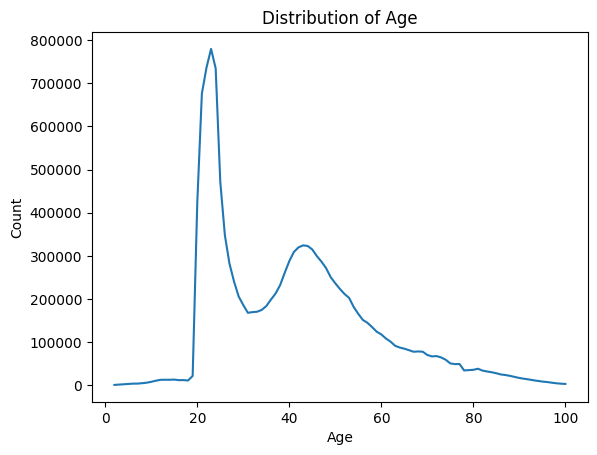

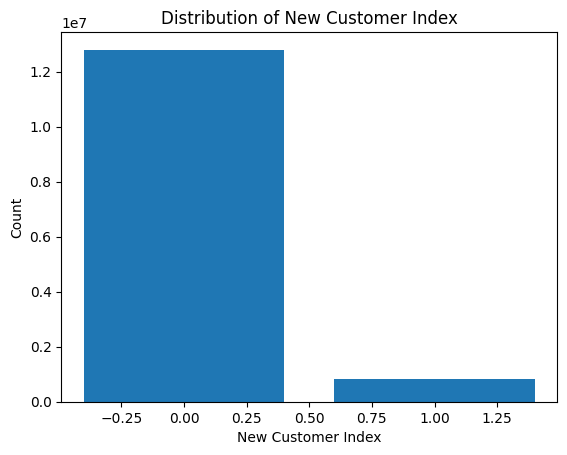

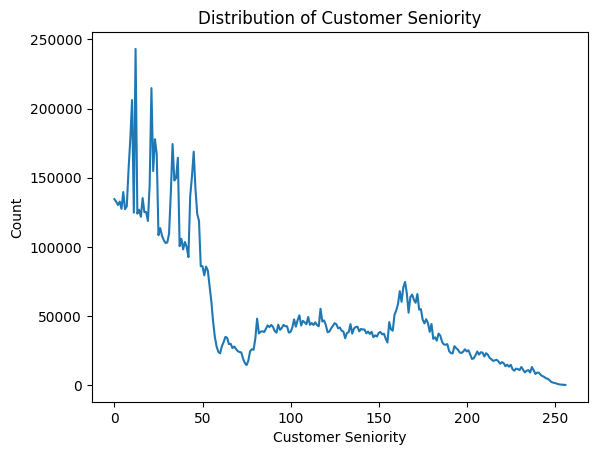

In [22]:
demographic_cols = [
    "sex",
    "age",
    "country_residence",
    "new_customer_index",
    "customer_seniority"
]
demographics_df = train_data.select(demographic_cols)

# Summary statistics for numerical columns
demographics_df.describe("age", "customer_seniority").show()

# age
age_distribution = demographics_df.groupBy("age").count().orderBy("age").collect()
age_values = [row["age"] for row in age_distribution]
age_counts = [row["count"] for row in age_distribution]
plt.plot(age_values, age_counts)
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


# new customer index
new_customer_distribution = demographics_df.groupBy("new_customer_index").count().collect()
new_customer_labels = [row["new_customer_index"] for row in new_customer_distribution]
new_customer_counts = [row["count"] for row in new_customer_distribution]
plt.bar(new_customer_labels, new_customer_counts)
plt.title("Distribution of New Customer Index")
plt.xlabel("New Customer Index")
plt.ylabel("Count")
plt.show()

# Customer seniority
customer_seniority_distribution = demographics_df.groupBy("customer_seniority").count().orderBy("customer_seniority").collect()
seniority_values = [row["customer_seniority"] for row in customer_seniority_distribution]
seniority_counts = [row["count"] for row in customer_seniority_distribution]
plt.plot(seniority_values, seniority_counts)
plt.title("Distribution of Customer Seniority")
plt.xlabel("Customer Seniority")
plt.ylabel("Count")
plt.show()


In [23]:
from pyspark.sql.functions import when, col

def create_age_groups_and_weighted_activity(df, age_column="age"):
    age_groups = {"young": (0, 25), "adult": (26, 40), "middle-aged": (41, 60), "senior": (61, 100)}

    df_with_age_groups_and_weighted_activity = df.withColumn("age_group",
                                      when((col(age_column) >= age_groups["young"][0]) & (col(age_column) <= age_groups["young"][1]), "young")
                                      .when((col(age_column) >= age_groups["adult"][0]) & (col(age_column) <= age_groups["adult"][1]), "adult")
                                      .when((col(age_column) >= age_groups["middle-aged"][0]) & (col(age_column) <= age_groups["middle-aged"][1]), "middle-aged")
                                      .when(col(age_column) >= age_groups["senior"][0], "senior")
                                      .otherwise("unknown")) \
                                      .withColumn("activity_index_weighted", col("customer_activity_index") * col("customer_seniority"))

    return df_with_age_groups_and_weighted_activity


train_data = create_age_groups_and_weighted_activity(train_data, age_column="age")
test_data_processed = create_age_groups_and_weighted_activity(test_data, age_column="age")


In [24]:

product_columns = [
    "savings_account", "guarantees", "current_accounts", "derivada_account", "payroll_account",
    "junior_account", "mas_particular_account", "particular_account", "particular_plus_account",
    "short_term_deposits", "medium_term_deposits", "long_term_deposits", "e_account", "funds",
    "mortgage", "loans", "taxes", "credit_card", "securities", "home_account", "payroll",
    "pensions_nom", "pension_plans", "direct_debit"
]

def process_train_data(df):
    for col_name in product_columns:
        df = df.withColumn(col_name, when(col(col_name).isNull(), 0).otherwise(col(col_name)))
    df = df.withColumn("multi_label", concat_ws('_', *product_columns))
    return df


def process_test_data(df):
    return df


def create_feature_pipeline():
    categorical_cols = [
        "employee_index", "country_residence", "sex", "new_customer_index",
        "primary_customer_index", "province_code", "customer_type_start_month",
        "customer_relation_type_start_month", "residence_index", "foreigner_index",
        "deceased_index", "customer_activity_index", "customer_segment",
        "age_group", "activity_index_weighted"
    ]

    string_indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid='keep') for col in categorical_cols]
    one_hot_encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=col + "_encoded") for indexer, col in zip(string_indexers, categorical_cols)]
    encoded_columns = [col + "_encoded" for col in categorical_cols]
    feature_assembler = VectorAssembler(inputCols=encoded_columns, outputCol="features")

    return Pipeline(stages=string_indexers + one_hot_encoders + [feature_assembler])

In [25]:
# Create and fit the feature pipeline
feature_pipeline_train_data = create_feature_pipeline()
fitted_pipeline_train_data = feature_pipeline_train_data.fit(train_data)
transformed_train_data_for__original_intermediate = fitted_pipeline_train_data.transform(train_data)


# Create a single target column by concatenating all product columns for training data
transformed_train_data_for__original_intermediate = transformed_train_data_for__original_intermediate.withColumn("multi_label", concat_ws('_', *product_columns))

# Index the target column to convert string labels to numeric indices
target_indexer = StringIndexer(inputCol="multi_label", outputCol="label").fit(transformed_train_data_for__original_intermediate)
transformed_train_data_for__original_intermediate = target_indexer.transform(transformed_train_data_for__original_intermediate)

In [26]:
historical_data = train_data.filter(col("date") <= "2016-04-28")
intermediate_data_0528 = train_data.filter(col("date") == "2016-05-28")

In [27]:
historical_data = process_train_data(historical_data)
intermediate_data_0528 = process_train_data(intermediate_data_0528)
test_data = process_test_data(test_data_processed)

In [28]:
# Create and fit the feature pipeline
feature_pipeline = create_feature_pipeline()
fitted_pipeline = feature_pipeline.fit(historical_data)

In [29]:
# Transform all datasets
transformed_historical_data = fitted_pipeline.transform(historical_data)
transformed_intermediate_data_0528 = fitted_pipeline.transform(intermediate_data_0528)
transformed_test_data = fitted_pipeline.transform(test_data)

In [30]:
# Create a single target column by concatenating all product columns for training data
train_data = transformed_historical_data.withColumn("multi_label", concat_ws('_', *product_columns))

# Index the target column to convert string labels to numeric indices
target_indexer = StringIndexer(inputCol="multi_label", outputCol="label").fit(train_data)
train_data = target_indexer.transform(train_data)

In [31]:
# Show transformed data for verification
train_data.select("label", "features").show(truncate=False)
transformed_intermediate_data_0528.select("features").show(truncate=False)
transformed_test_data.select("features").show(truncate=False)
transformed_train_data_for__original_intermediate.select("label","features").show(truncate=False)

+-----+-----------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                     |
+-----+-----------------------------------------------------------------------------------------------------------------------------+
|0.0  |(460,[0,5,124,125,127,135,181,186,189,191,193,196,197,202,219],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|0.0  |(460,[0,5,123,125,127,153,181,185,189,191,193,195,198,201,204],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|0.0  |(460,[0,5,123,125,127,153,181,185,189,191,193,195,198,201,204],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|81.0 |(460,[0,5,124,125,127,136,181,185,189,191,193,195,198,201,204],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|0.0  |(460,[0,5,123,125,127,136,181,186,189,191,193,196,198,2

In [32]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.utils import AnalysisException

# Define the paths to save the Parquet files on Google Drive
parquet_path1 = '/content/drive/My Drive/santander-product-recommendation/train_data.parquet'
parquet_path2 = '/content/drive/My Drive/santander-product-recommendation/transformed_intermediate_data_0528.parquet'
parquet_path3 = '/content/drive/My Drive/santander-product-recommendation/transformed_test_data.parquet'
parquet_path4 = '/content/drive/My Drive/santander-product-recommendation/transformed_train_data_for_original_intermediate.parquet'

# Function to save DataFrame to Parquet with overwrite mode and error handling
def save_dataframe(df, path):
    try:
        df.write.mode('overwrite').parquet(path)
        print(f"DataFrame saved to {path}")
    except AnalysisException as e:
        print(f"Failed to save DataFrame to {path}. Error: {e}")

In [29]:
save_dataframe(transformed_train_data_for__original_intermediate, parquet_path4)

DataFrame saved to /content/drive/My Drive/santander-product-recommendation/transformed_train_data_for_original_intermediate.parquet


In [ ]:
save_dataframe(train_data, parquet_path1)

In [ ]:
save_dataframe(transformed_intermediate_data_0528, parquet_path2)

In [ ]:
save_dataframe(transformed_test_data, parquet_path3)